In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_squared_error, r2_score
import time
import random

sns.set(style="ticks", color_codes=True);
sns.set_style('white',{'font.sans-serif':['simhei','Arial']})

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

Using TensorFlow backend.


In [2]:
# date-time parsing function for loading the dataset
def parser(x):
  return datetime.strptime(x, '%Y/%m/%d')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
  df = DataFrame(data)
  columns = [df.shift(i) for i in range(1, lag+1)]
  columns.append(df)
  df = concat(columns, axis=1)
  df.fillna(0, inplace=True)
  return df

# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
      value = dataset[i] - dataset[i - interval]
      diff.append(value)
  return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
  # fit scaler
  scaler = MinMaxScaler(feature_range=(-1, 1))
  scaler = scaler.fit(train)
  # transform train
  train = train.reshape(train.shape[0], train.shape[1])
  train_scaled = scaler.transform(train)
  # transform test
  test = test.reshape(test.shape[0], test.shape[1])
  test_scaled = scaler.transform(test)
  return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
  new_row = [x for x in X] + [value]
  array = numpy.array(new_row)
  array = array.reshape(1, len(array))
  inverted = scaler.inverse_transform(array)
  return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
  X, y = train[:, 0:-1], train[:, -1]
  X = X.reshape(X.shape[0], 1, X.shape[1])
  model = Sequential()
  model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  for i in range(nb_epoch):
      model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
      model.reset_states()
  return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
  X = X.reshape(1, 1, len(X))
  yhat = model.predict(X, batch_size=batch_size)
  return yhat[0,0]


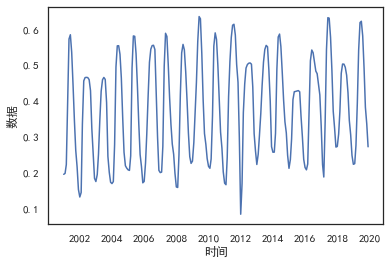

In [21]:
# load dataset
series = read_csv('A001.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
series 

plt.plot(series )
plt.ylabel('数据')
plt.xlabel('时间')
plt.show()
#data = year_df[["数据"]]


#data.head()

In [22]:

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)



# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-36], supervised_values[-36:]

In [23]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[-0.07189111],
       [ 0.02259271],
       [ 0.33625388],
       [ 0.6367421 ],
       [-0.10875174],
       [-0.22117326],
       [-0.44148198],
       [-0.4711313 ],
       [-0.4097094 ],
       [-0.2660277 ],
       [-0.17742577],
       [-0.15439624],
       [-0.03919973],
       [ 0.27109116],
       [ 0.49514815],
       [ 0.18805677],
       [-0.16775016],
       [-0.09567315],
       [-0.09224752],
       [-0.1832686 ],
       [-0.46276233],
       [-0.4151593 ],
       [-0.28010207],
       [-0.19875604],
       [-0.00725974],
       [ 0.34402582],
       [ 0.5446635 ],
       [ 0.2571311 ],
       [ 0.07726225],
       [-0.02327341],
       [-0.17824328],
       [-0.19157112],
       [-0.55993223],
       [-0.4464231 ],
       [-0.25601172],
       [-0.13928759],
       [ 0.07052494],
       [ 0.19800676],
       [ 0.6830791 ],
       [ 0.1807224 ],
       [-0.07749423],
       [-0.17629251],
       [-0.34118938],
       [-0.4127634 ],
       [-0.4231766 ],
       [-0

In [12]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
  # make one-step forecast
  X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
  yhat = forecast_lstm(lstm_model, 1, X)
  # invert scaling
  yhat = invert_scale(scaler, X, yhat)
  # invert differencing
  yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
  # store forecast
  predictions.append(yhat)
  expected = raw_values[len(train) + i + 1]
  #print('DateNum=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
  print('Predicted=%f' % ( yhat))

Predicted=0.403826
Predicted=0.293862
Predicted=0.180414
Predicted=0.163867
Predicted=0.506064
Predicted=0.612616
Predicted=0.637491
Predicted=0.564539
Predicted=0.490094
Predicted=0.413152
Predicted=0.318476
Predicted=0.282568
Predicted=0.243164
Predicted=0.317422
Predicted=0.423596
Predicted=0.493234
Predicted=0.549914
Predicted=0.473290
Predicted=0.480576
Predicted=0.449740
Predicted=0.402527
Predicted=0.349348
Predicted=0.291844
Predicted=0.279781
Predicted=0.220225
Predicted=0.221263
Predicted=0.275673
Predicted=0.423049
Predicted=0.492255
Predicted=0.598245
Predicted=0.657739
Predicted=0.579439
Predicted=0.491610
Predicted=0.397530
Predicted=0.308999
Predicted=0.280239


In [19]:
#to_csv('b1.CSV',sep=',',index=TRUE, header=TRUE)
#report performance
#expected = raw_values[len(train) + i + 1]
#print('Predicted=%f' % ( yhat))
rmse = sqrt(mean_squared_error(raw_values[-36:], predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.042


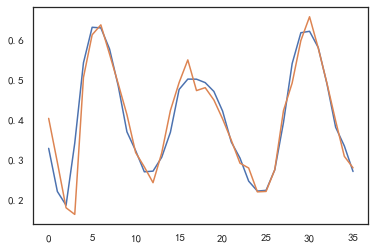

array([0.328904  , 0.22116099, 0.186799  , 0.34206501, 0.54268402,
       0.63139999, 0.62992698, 0.57717299, 0.48470899, 0.37018901,
       0.32324299, 0.27034   , 0.27199101, 0.306696  , 0.36915901,
       0.47616699, 0.50194901, 0.501737  , 0.49312699, 0.471084  ,
       0.42201901, 0.34479699, 0.30465201, 0.24698999, 0.222215  ,
       0.22398899, 0.27525699, 0.39333701, 0.54074001, 0.61777002,
       0.62138301, 0.58071601, 0.490269  , 0.38163501, 0.334997  ,
       0.271099  ])

In [20]:
# line plot of observed vs predicted
pyplot.plot(raw_values[-36:])
pyplot.plot(predictions)
pyplot.show()
raw_values[-36:]